In [1]:
import os

In [1]:
# !nvidia-smi

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [4]:
import numpy as np
import torch
from torch import nn
from tqdm.notebook import tqdm
from torchsummary import summary
from torch import from_numpy
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import json
import PIL.Image

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
data = np.load('tests/00_unittest_classifier_input/train_data.npz')

In [7]:
data['X'].shape

(1050, 40, 100, 1)

In [21]:
def get_cls_model(input_shape=(1, 40, 100)):
    """
    :param input_shape: tuple (n_rows, n_cols, n_channels)
            input shape of image for classification
    :return: nn model for classification
    """
    # your code here \/
    classification_model = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, padding='same'),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(32, 64, kernel_size=3, padding='same'),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 128, kernel_size=3, padding='same'),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(128, 128, kernel_size=3, padding='same'),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.Flatten(),
        nn.Linear(5 * 12 * 128, 2),
        nn.Sigmoid(),
    )
    return classification_model
    # your code here /\


In [22]:
model = get_cls_model().to(device)
summary(model, (1, 40, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 40, 100]             320
       BatchNorm2d-2          [-1, 32, 40, 100]              64
              ReLU-3          [-1, 32, 40, 100]               0
         MaxPool2d-4           [-1, 32, 20, 50]               0
            Conv2d-5           [-1, 64, 20, 50]          18,496
       BatchNorm2d-6           [-1, 64, 20, 50]             128
              ReLU-7           [-1, 64, 20, 50]               0
         MaxPool2d-8           [-1, 64, 10, 25]               0
            Conv2d-9          [-1, 128, 10, 25]          73,856
      BatchNorm2d-10          [-1, 128, 10, 25]             256
             ReLU-11          [-1, 128, 10, 25]               0
        MaxPool2d-12           [-1, 128, 5, 12]               0
           Conv2d-13           [-1, 128, 5, 12]         147,584
      BatchNorm2d-14           [-1, 128

In [23]:
def fit_cls_model(X, y, fast_train=True):
    """
    :param X: 4-dim tensor with training images
    :param y: 1-dim tensor with labels for training
    :return: trained nn model
    """
    # your code here \/
    model = get_cls_model().to(device)
    loss_fn = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    num_epochs = 5 if fast_train == False else 1
    
    for e in range(num_epochs):
        model = model.train()
        train_loss = []
        progress_train = tqdm(
            total=len(X),
            desc=f"Epoch {e}",
            leave=False,
        )
        for k, (x_batch, y_batch) in enumerate(zip(X, y)):
            if fast_train == True and k == 2:
                break
                
            x_batch = x_batch.to(device).unsqueeze(0)
            y_batch = y_batch.to(device).unsqueeze(0)
            p_batch = model(x_batch)
            loss = loss_fn(p_batch, y_batch)
            train_loss.append(loss.detach())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            progress_train.update()
        
        progress_train.close()

        train_loss = torch.stack(train_loss).mean()
        print(
            f"Epoch {e},",
            f"train_loss: {train_loss.item():.8f}",
        )

    if fast_train == False:
        torch.save(model.state_dict(), "classifier_model.pt")
    else:
        model.load_state_dict(torch.load("classifier_model.pt", map_location='cpu', weights_only=True))

    return model.to(torch.device('cpu'))
    # your code here /\

In [24]:
X = data['X'].reshape(-1, 1, 40, 100)   #pytorch dimensions are (N, C, H, W)
y = data['y'].astype(np.int64)
X = from_numpy(X)
y = from_numpy(y)

In [25]:
model = fit_cls_model(X, y, False)
model.to(device);

Epoch 0:   0%|          | 0/1050 [00:00<?, ?it/s]

Epoch 0, train_loss: 0.36005771


Epoch 1:   0%|          | 0/1050 [00:00<?, ?it/s]

Epoch 1, train_loss: 0.32556537


Epoch 2:   0%|          | 0/1050 [00:00<?, ?it/s]

Epoch 2, train_loss: 0.32945144


Epoch 3:   0%|          | 0/1050 [00:00<?, ?it/s]

Epoch 3, train_loss: 0.33024275


Epoch 4:   0%|          | 0/1050 [00:00<?, ?it/s]

Epoch 4, train_loss: 0.32629263


In [27]:
X = data['X'].reshape(-1, 1, 40, 100)   #pytorch dimensions are (N, C, H, W)
y = data['y'].astype(np.int64)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train, X_test = from_numpy(X_train), from_numpy(X_test)
y_train, y_test = from_numpy(y_train), from_numpy(y_test)

In [28]:
y_predicted = torch.argmax(model(X_test.to(device)), dim = 1).cpu()
print(y_predicted.shape)
print(y_test.shape)
print(accuracy_score(y_test, y_predicted))

torch.Size([263])
torch.Size([263])
1.0


In [29]:
def get_detection_model(cls_model):
    """
    :param cls_model: trained cls model
    :return: fully convolutional nn model with weights initialized from cls
             model
    """
    # your code here \/
    detection_model = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3,padding='same'),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(32, 64, kernel_size=3, padding='same'),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 128, kernel_size=3, padding='same'),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(128, 128, kernel_size=3, padding='same'),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.Conv2d(128, 2, kernel_size=(5, 12)),
        nn.Softmax(dim=1),
    )

    # inspired by https://discuss.pytorch.org/t/how-to-copy-weights-from-one-model-to-another-model-instance-wise/17163/2
    # and for deepcopy https://discuss.pytorch.org/t/copy-a-block-of-layers-from-a-model/80618
    for i in range(15):
        # detection_model[i].weight.data.copy_(cls_model[i].weight.data)
        # detection_model[i].bias.data.copy_(cls_model[i].bias.data)
        detection_model[i] = copy.deepcopy(cls_model[i])
    detection_model[15].weight.data.copy_(cls_model[16].weight.data.reshape(detection_model[15].weight.data.shape))
    detection_model[15].bias.data.copy_(cls_model[16].bias.data.reshape(detection_model[15].bias.data.shape))

    return detection_model
    # your code here /\

In [30]:
d_m = get_detection_model(model).to('cpu')

In [31]:
y_predicted = torch.argmax(d_m(X_test), dim = 1).squeeze().cpu()
print(y_predicted.shape)
print(y_test.shape)
print(accuracy_score(y_test, y_predicted))

torch.Size([263])
torch.Size([263])
1.0


In [32]:
def read_for_detection(img_dir, gt_path):
    with open(gt_path) as fp:
        raw_data = json.load(fp)

    data = {}
    for file_name, bboxes in raw_data.items():
        file_path = os.path.join(img_dir, file_name)
        image = np.array(PIL.Image.open(file_path))
        image = image.astype(np.float32) / 255
        data[file_name] = (image, bboxes)
    return data

In [34]:
data = read_for_detection('tests/03_unittest_detector_input/test_imgs', 'tests/03_unittest_detector_input/true_detections.json')

In [35]:
data['test-0.png'][0].shape

(115, 210)

In [36]:
pred = d_m(from_numpy(data['test-0.png'][0]).unsqueeze(0).unsqueeze(1))

In [ ]:
heatmap = pred[0][1]
heatmap

In [38]:
heatmap.shape

torch.Size([10, 15])

In [39]:
from matplotlib.patches import Rectangle

Image = (115, 210), heatmap = (10, 15)


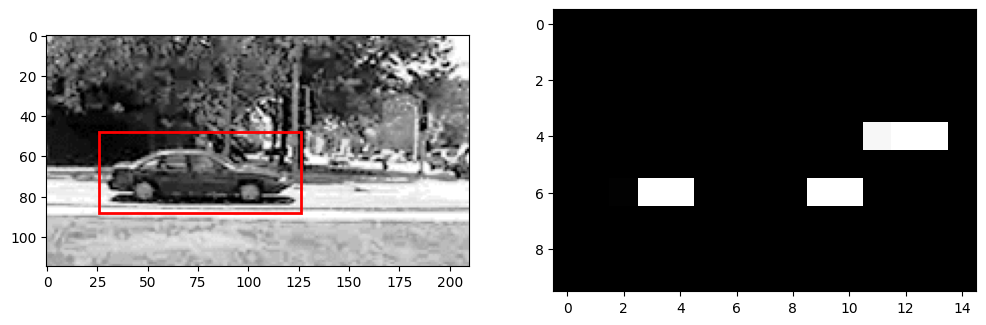

In [40]:
img = data['test-0.png'][0]
h, w, height, width = data['test-0.png'][1][0]

img_tensor = torch.tensor(img).expand(1, 1, *img.shape)
detection = d_m(img_tensor)
detection = detection[0][1].detach().cpu().numpy()
print(f'Image = {img.shape}, heatmap = {detection.shape}')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(img, cmap='gray')
ax[0].add_patch(Rectangle((w, h), width, height, linewidth=2, edgecolor='r', facecolor='none'))
ax[1].imshow(detection, cmap='gray')

plt.show()

In [41]:
def get_detections(detection_model, dictionary_of_images):
    """
    :param detection_model: trained fully convolutional detector model
    :param dictionary_of_images: dictionary of images in format
        {filename: ndarray}
    :return: detections in format {filename: detections}. detections is a N x 5
        array, where N is number of detections. Each detection is described
        using 5 numbers: [row, col, n_rows, n_cols, confidence].
    """
    # your code here \/

    model_h = 40
    model_w = 100
    model_stride = 8
    threshold = 0.9
    detection_model.eval()
    detections_dict = {}
    for name, img in dictionary_of_images.items():
        detections = detection_model(from_numpy(img).unsqueeze(0).unsqueeze(1))
        detections = detections[0][1].detach().cpu().numpy()
        bboxes = []
        for i in range(len(detections)):
            for j in range(len(detections[i])):
                if detections[i][j] > threshold:
                    bboxes.append([i * model_stride, j * model_stride, model_h, model_w, detections[i][j]])
        detections_dict[name] = bboxes
                    
    return detections_dict
    # your code here /\

In [42]:
test_data ={}
for fname, d in list(data.items()):
    test_data[fname] = d[0]

In [43]:
dd = get_detections(d_m, test_data)

In [ ]:
dd

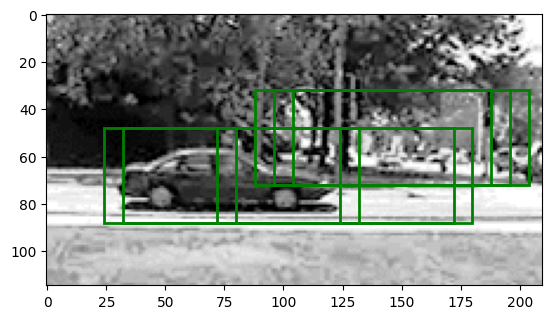

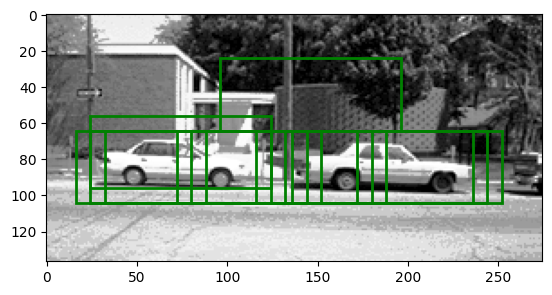

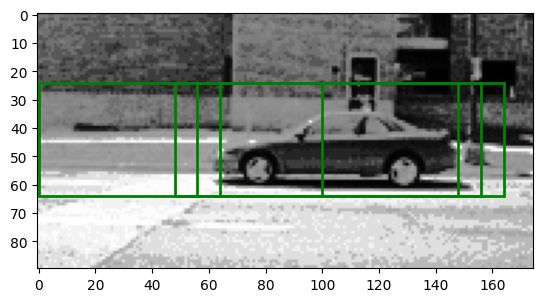

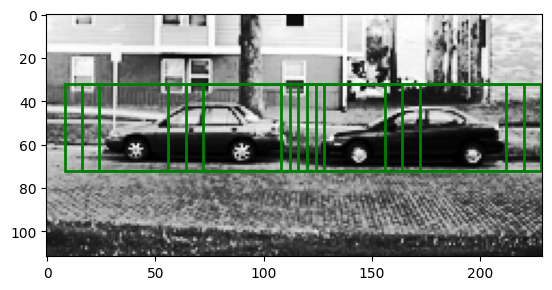

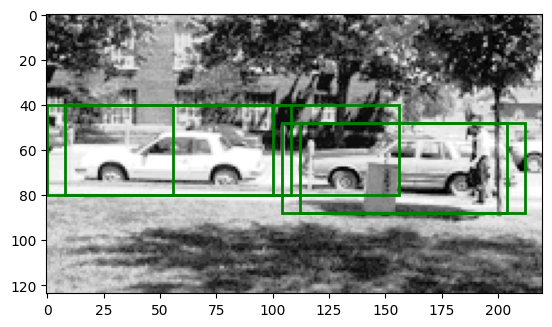

In [45]:
i = 0
for filename, dets in dd.items():
    img = test_data[filename]
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    for det in dets:
        h, w, height, width, _ = det
        ax.add_patch(Rectangle((w, h), width, height, linewidth=2, edgecolor='g', facecolor='none'))
    i += 1
    if i == 5:
        break

In [11]:
def calc_iou(first_bbox, second_bbox):
    """
    :param first bbox: bbox in format (row, col, n_rows, n_cols)
    :param second_bbox: bbox in format (row, col, n_rows, n_cols)
    :return: iou measure for two given bboxes
    """
    # your code here \/
    if abs(first_bbox[0] - second_bbox[0]) > max(first_bbox[2], second_bbox[2]) or\
       abs(first_bbox[1] - second_bbox[1]) > max(first_bbox[3], second_bbox[3]):
        return 0
    x1 = max(first_bbox[0], second_bbox[0])
    y1 = max(first_bbox[1], second_bbox[1])
    x2 = min(first_bbox[0] + first_bbox[2], second_bbox[0] + second_bbox[2])
    y2 = min(first_bbox[1] + first_bbox[3], second_bbox[1] + second_bbox[3])
    intersection = abs(x2 - x1) * abs(y1 - y2)
    first_area = first_bbox[2] * first_bbox[3]
    second_area = second_bbox[2] * second_bbox[3]
    return intersection / (first_area + second_area - intersection)
    # your code here /\


# =============================== 6 AUC ========================================
def calc_auc(pred_bboxes, gt_bboxes):
    """
    :param pred_bboxes: dict of bboxes in format {filename: detections}
        detections is a N x 5 array, where N is number of detections. Each
        detection is described using 5 numbers: [row, col, n_rows, n_cols,
        confidence].
    :param gt_bboxes: dict of bboxes in format {filenames: bboxes}. bboxes is a
        list of tuples in format (row, col, n_rows, n_cols)
    :return: auc measure for given detections and gt
    """
    # your code here \/
    all_tp = []
    all_fp = []
    all_ = []
    all_gt_counter = 0
    for img in gt_bboxes.keys():
        gt = gt_bboxes[img].copy()
        all_gt_counter += len(gt)
        sorted_preds = sorted(pred_bboxes[img], key=lambda x: x[-1], reverse=True)
        for pred in sorted_preds:
            found = False
            best_gt_iou = 0.
            if gt:
                best_gt_iou = max(calc_iou(pred[:-1], gt[i]) for i in range(len(gt)))
            if best_gt_iou >= 0.5:
                all_tp.append(pred)
                found = True
                if gt:
                    max_gt_idx = np.argmax([calc_iou(pred[:-1], gt[i]) for i in range(len(gt))])
                    del gt[max_gt_idx]
            if found == False:
                all_fp.append(pred)

    all_ = all_tp + all_fp
    all_ = sorted(all_, key=lambda x: x[-1])
    all_tp = sorted(all_tp, key=lambda x: x[-1])
    roc = []

    confs = []
    tp_conf_idx = 0
    for i in range(len(all_)):
        conf = all_[i][-1]
        if conf in confs:
            continue
        else:
            confs.append(conf)
            
        all_more_confident = len(all_) - i
        while tp_conf_idx < len(all_tp) and all_tp[tp_conf_idx][-1] < conf:
            tp_conf_idx += 1
        tp_more_confident = len(all_tp) - tp_conf_idx

        precision = tp_more_confident / all_more_confident
        recall    = tp_more_confident / all_gt_counter
        roc.append((recall, precision, conf))
    roc.append((0, 1, 1))

    auc = 0
    for i in range(len(roc) - 1):
        auc += 0.5 * (roc[i][1] + roc[i + 1][1]) * (roc[i][0] - roc[i + 1][0])

    return auc
    # your code here /\



In [47]:
def calc_detector_auc(img_dir, gt_path, apply_nms=False):
    classifier_model = get_cls_model()
    classifier_model.load_state_dict(
        torch.load(
            "classifier_model.pt",
            weights_only=True,
            map_location="cpu",
        ),
    )
    detection_model = get_detection_model(classifier_model)
    images_detection = read_for_detection(img_dir, gt_path)
    images_detection_no_answer = {}
    images_detection_only_bboxes = {}

    for img_name, data in images_detection.items():
        images_detection_no_answer[img_name] = data[0]
        images_detection_only_bboxes[img_name] = data[1]

    pred = get_detections(detection_model, images_detection_no_answer)
    if apply_nms:
        pred = nms(pred)

    return calc_auc(pred, images_detection_only_bboxes)


In [48]:
from os.path import dirname, join
# test_dir = dirname(__file__)
img_dir = 'tests/03_unittest_detector_input/test_imgs'
gt_path = 'tests/03_unittest_detector_input/true_detections.json'
score = calc_detector_auc(img_dir, gt_path)

In [49]:
score

0.6385044376923542

In [90]:
def nms(detections_dictionary, iou_thr=0.7):
    """
    :param detections_dictionary: dict of bboxes in format {filename: detections}
        detections is a N x 5 array, where N is number of detections. Each
        detection is described using 5 numbers: [row, col, n_rows, n_cols,
        confidence].
    :param iou_thr: IoU threshold for nearby detections
    :return: dict in same format as detections_dictionary where close detections
        are deleted
    """
    # your code here \/
    filtered_detections_dictionary = {}
    for img in detections_dictionary.keys():
        sorted_preds = sorted(detections_dictionary[img], key=lambda x: x[-1], reverse=True)
        filtered_preds = [sorted_preds[0]]
        for pred in sorted_preds[1:]:
            remove = False
            for filtered_pred in filtered_preds:
                if calc_iou(filtered_pred[:-1], pred[:-1]) >= iou_thr:
                    remove = True
                    break
            if not remove:
                filtered_preds.append(pred)
        filtered_detections_dictionary[img] = filtered_preds
    return filtered_detections_dictionary
    # your code here /\

In [91]:
predictions = {'1': [[0.0, 0.0, 40.0, 100.0, 0.0001439873068488249],
                   [0.0, 0.0, 40.0, 100.0, 0.0001439873068488249],
                   [0.0, 8.0, 40.0, 100.0, 8.844506876789047e-05],
                   [0.0, 12.0, 40.0, 100.0, 8.864786832494879e-05],
                   [0.0, 16.0, 40.0, 100.0, 5.646329540611465e-05],
                   [0.0, 20.0, 40.0, 100.0, 5.32966834220056e-05],
                   [0.0, 24.0, 40.0, 100.0, 3.776895335082916e-05],
                   [0.0, 12.0, 40.0, 100.0, 8.864786832494879e-05],
                   [0.0, 24.0, 40.0, 100.0, 3.776895335082916e-05],
                   [0.0, 16.0, 40.0, 100.0, 5.646329540611465e-05],
                   [0.0, 32.0, 40.0, 100.0, 2.122202754350387e-05],
                   [0.0, 20.0, 40.0, 100.0, 5.32966834220056e-05],
                   [0.0, 20.0, 40.0, 100.0, 5.32966834220056e-05],
                   [0.0, 16.0, 40.0, 100.0, 5.646329540611465e-05],
                   [0.0, 28.0, 40.0, 100.0, 2.6099790148424712e-05],
                   [0.0, 52.0, 40.0, 100.0, 1.1105166866133818e-05],
                   [0.0, 24.0, 40.0, 100.0, 3.776895335082916e-05],
                   [0.0, 0.0, 40.0, 100.0, 0.0001439873068488249],
                   [0.0, 68.0, 40.0, 100.0, 7.211932406036818e-06],
                   [0.0, 64.0, 40.0, 100.0, 6.360868819693369e-06]]}
true_nms = [[0, 0, 40, 100], [0, 28, 40, 100], [0, 68, 40, 100]]

In [92]:
nms(predictions)

{'1': [[0.0, 0.0, 40.0, 100.0, 0.0001439873068488249],
  [0.0, 20.0, 40.0, 100.0, 5.32966834220056e-05],
  [0.0, 52.0, 40.0, 100.0, 1.1105166866133818e-05]]}